<a id="top"></a>

<a id = '1.0'></a>
<h1 style = "font-family: garamond; font-size: 40px; font-style: normal;background-color: #2ab7ca; color : #fed766; border-radius: 5px 5px;padding:5px;text-align:center; font-weight: bold" >Quick Navigation</h1>

    
* [Dependencies and Configuration](#1)
* [Stage 2: EDA: Preliminary Stage](#2)
    * [Distribution of Target and Predictor](#31)
        * [Target Distribution](#31)
        * [Univariate Distribution of Predictors](#31)
            * [Histogram and KDE Distribution](#31)
            * [Box Plots](#31)
         
    * [Correlation Plots](#31)
        * [Heatmap](#31)
        * [Cluster Plot](#31)
    * [Bivariate Analysis](#31)
    * [PCE and TSNE](#31)
    * [Save the Data](#31)

# Dependencies and Configuration

In [24]:
import random
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr, spearmanr
from sklearn import decomposition, manifold, preprocessing

In [25]:
class global_config:
    
    # File Path
    raw_data = "../data/raw/data.csv"
    processed_data_stage_1 = "../data/processed/data_stage_1.csv"
    processed_data_stage_2 = "../data/processed/data_stage_2.csv"
    processed_data_stage_3 = "../data/processed/data_stage_3.csv"

    # Data Information
    target = ["diagnosis"]
    unwanted_cols = ["id", "Unnamed: 32"]

    # Plotting
    colors = ["#fe4a49", "#2ab7ca", "#fed766", "#59981A"]
    cmap_reversed = plt.cm.get_cmap('mako_r')
    
    # Seed Number
    seed = 1992

    # Cross Validation
    num_folds = 5
    cv_schema = "StratifiedKFold"
    split_size = {"train_size": 0.9, "test_size": 0.1}


def set_seeds(seed: int = 1234) -> None:
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)

In [26]:
# set config
config = global_config

# set seeding for reproducibility
_ = set_seeds(seed = config.seed)

# read data
df = pd.read_csv(config.processed_data_stage_1)

# Stage 2: EDA : Preliminary Stage

<div class="alert alert-warning" role="alert">
    <b> Terminology Alert! </b> I call this stage the preliminary EDA for the following reasons (but not limited to!)
    <li> EDA is an iterative process! Data is never clean! So we scrub -> send in for modelling -> scrub -> get new data -> scrub scrub scrub again!
    <li> Typically, in my pipeline, after stage 1, I do a basic EDA analysis. As an example, in a classical regression setting, I would check for some assumptions like normality checks. And if some variables are of a "bad distribution", we can perform a transformation on it first, and plot them again in the next round of EDA to check if we corrected the issues. 
</div>

The below image summarizes the process.

<figure>
<img src='https://drive.google.com/uc?id=1xmDFzMhs3AbssI1z7zb1yO-FjBI3ewis' width="500"/>
<figcaption align = "center"><b>Courtesy of <a href="https://en.wikipedia.org/wiki/User:Farcaster">Farcaster</a></b></figcaption>
</figure>

---

In summary, we will do the following EDA here:

- Target and Predictors Distribution.
- Univariate Analysis.
- Bivariate Analysis.
- Multivariate Analysis.
- Some fancy looking Dimensionality Reduction Techniques to see how our features can be visualized in lower dimensions.

## Distribution of Target and Predictor

### Target

Let us first visualize our distribution of target variable. Since the target is discrete, we will just plot a simple count plot to check.

---

<div class="alert alert-block alert-danger">
<b>Class Imbalance:</b> For Classification problems, we often plot the target count to get a good gauge on how imbalanced the dataset is. From there, we can think of whether the class imbalance is going to be a factor in our modelling process.
</div>

```python
df['diagnosis'].value_counts(normalize=True) * 100
Malignant: 37.3%
Benign: 62.7%
```

---

There is to certain degree a class imbalance issue, although this is not what I have envisioned in the first place. After all, it is just natural that there should be more negative (benign) than positive (malignant) cases, given that in the general population, there are much more people without cancer than those who do. Nevertheless, despite the slight imbalance issue, we should still take them into account and perform stratification during cross-validation later.

In [27]:
def plot_target_distribution(df: pd.DataFrame, target: str, colors: List[str]) -> None:
    """Plot Target Distribution with percentage labels.

    Args:
        df (pd.DataFrame): [description]
        target (str): [description]
        colors (List[str]): [description]
    """

    plt.rcParams["figure.dpi"] = 100
    plt.rcParams["savefig.dpi"] = 300

    x_axis = df["diagnosis"].value_counts().index
    y_axis = df["diagnosis"].value_counts()

    figure, target_bar = plt.subplots(figsize=(6, 4))
    sns.barplot(x=x_axis, y=y_axis, ax=target_bar, palette={1: colors[0], 0: colors[3]})
    

    # ax.legend(h, labels, title="Interested in politics")

    target_bar.set_xticklabels(["Benign", "Malignant"])
    target_bar.set_ylabel("Frequency Count")
    target_bar.legend(["Benign", "Malignant"], loc="upper right")
    target_bar.set_title("Count of Target (Diagnosis)", fontsize=16)
    figure.text(
        x=0.27,
        y=0.8,
        s="{:.1f}%".format(df["diagnosis"].value_counts(normalize=True)[0] * 100),
        **{"weight": "bold", "color": "black"},
    )
    figure.text(
        x=0.66,
        y=0.5,
        s="{:.1f}%".format(df["diagnosis"].value_counts(normalize=True)[1] * 100),
        **{"weight": "bold", "color": "black"},
    )

    plt.show()

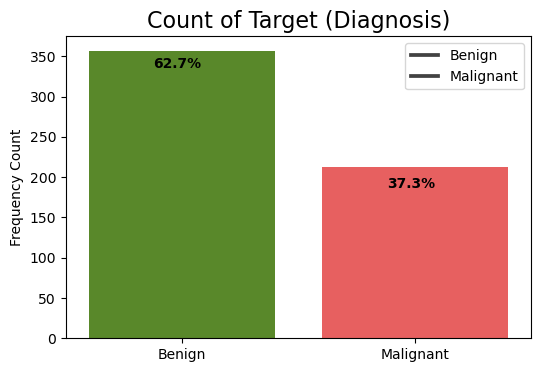

In [28]:
_ = plot_target_distribution(df=df, target=config.target[0], colors= config.colors)

### Univariate Distributions of Predictors

<div class="alert alert-info" role="alert">
    <b> Univariate Plot on Continuous Variables</b>
The predictors are all continuous variables. We can do a univariate plot to show the histogram/kde distribution of these features, we color the hue so that the distribution is parametrized by the target. In addition, we will also perform a box plot to check for potential outliers.
</div>

In [29]:
predictor_cols = df.columns.to_list()[1:]

#### Histogram and KDE distribution

We can plot a histogram with KDE for each of the feature, parametrized by the target. The aim of this visual is to briefly see how skewed the features are, whether the features are gaussian, and also the distribution of each feature with respect to the target.

In [30]:
def plot_univariate(df: pd.DataFrame, predictor: str, colors: List[str]) -> None:
    """Take in continuous predictors and plot univariate distribution. Note in this setting, we have kde=True.

    Args:
        df (pd.DataFrame): [description]
        predictor (str): [description]
    """

    univariate_params = {"nrows": 10, "ncols": 3, "figsize": (12, 24), "dpi":80}

    fig, axs = plt.subplots(**univariate_params)

    for i, col in enumerate(predictor):
        sns.histplot(
            data=df,
            x=col,
            kde=True,
            hue="diagnosis",
            ax=axs[i % univariate_params["nrows"]][i // univariate_params["nrows"]],
            legend=False,
            palette={1: colors[0], 0: colors[3]},
        )
    plt.subplots_adjust(hspace=2)
    fig.suptitle("Breast Cancer Predictors Univariate Distribution", y=1.01, fontsize="x-large")
    fig.legend(df["diagnosis"].unique())
    fig.tight_layout()
    plt.show();

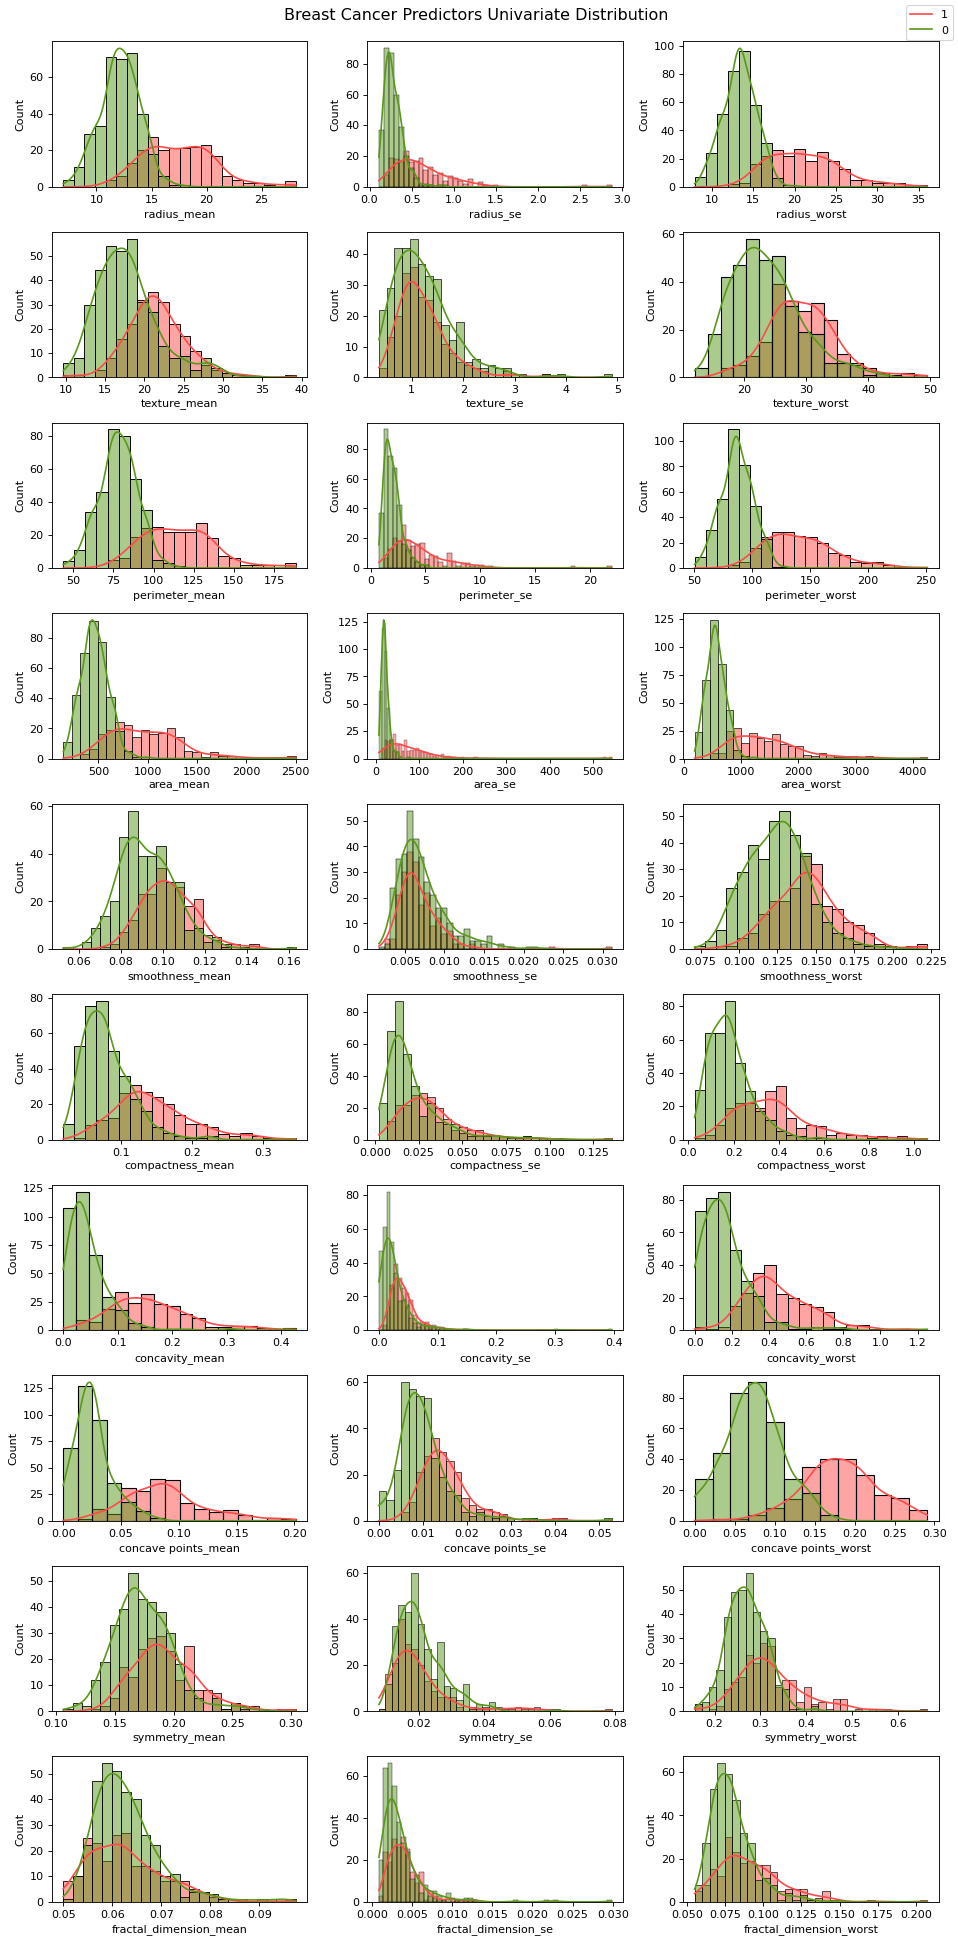

In [31]:
_ = plot_univariate(df=df, predictor=predictor_cols, colors=config.colors)

<div class="alert alert-block alert-success">
<b>Univariate Insights:</b> From the plots above, we can form very basic hypothesis on the features, we select a few features to explain:
    <li> <b>radius_mean</b>: seems to have a clear boundary to discriminate between benign and malignant classes; in general, the bigger the radius mean, the higher the likelihood of the tumor being malignant;
    <li> <b>smoothness_mean</b>: judging the smoothness mean (jaggedness) <b>alone</b>, we can see there is quite a fair bit of overlaps in between the class distributions, the boundary in between both classes are not so clear when compared to <b>radius_mean</b>. This suggests that the feature alone may not distinguish whether a patient's tumor is malignant or not. However, seemingly "non-informative" features may become extremely useful when coupled with other features. 
    <li> <b>right tail</b>: we can see most graphs are skewed towards the right.
</div>

#### Box Plots

Although a good alternative to box plots is the violin plot, but we do have the the distribution of KDE earlier on, so we can just zoom in at the box plots to check for outliers. There are some outliers present in the features. 

---

<div class="alert alert-block alert-danger">
<b>Outliers Alert!</b> Outliers are tricky, without domain knowledge, it is sometimes hard to tell whether or not an outlier should be removed. A rule of thumb is that if you are sure the outliers are caused by a labelling or human error, then you can remove them. Otherwise, we may need to investigate further to check if these outliers should be retained during modelling.
</div>

In [32]:
def plot_univariate_boxplot(df: pd.DataFrame, predictor: str) -> None:
    """Take in continuous predictors and plot univariate boxplot distribution. Note in this setting, we have kde=True.

    Args:
        df (pd.DataFrame): [description]
        predictor (str): [description]
    """

    univariate_params = {"nrows": 10, "ncols": 3, "figsize": (12, 24), "dpi": 80}

    fig, axs = plt.subplots(**univariate_params)

    for i, col in enumerate(predictor):
        sns.boxplot(
            data=df,
            x=col,
            hue="diagnosis",
            ax=axs[i % univariate_params["nrows"]][i // univariate_params["nrows"]]
        )
    plt.subplots_adjust(hspace=2)
    fig.suptitle("Breast Cancer Predictors Boxplot Distribution", y=1.01, fontsize="x-large")
    fig.legend(df["diagnosis"].unique())
    fig.tight_layout()
    plt.show();

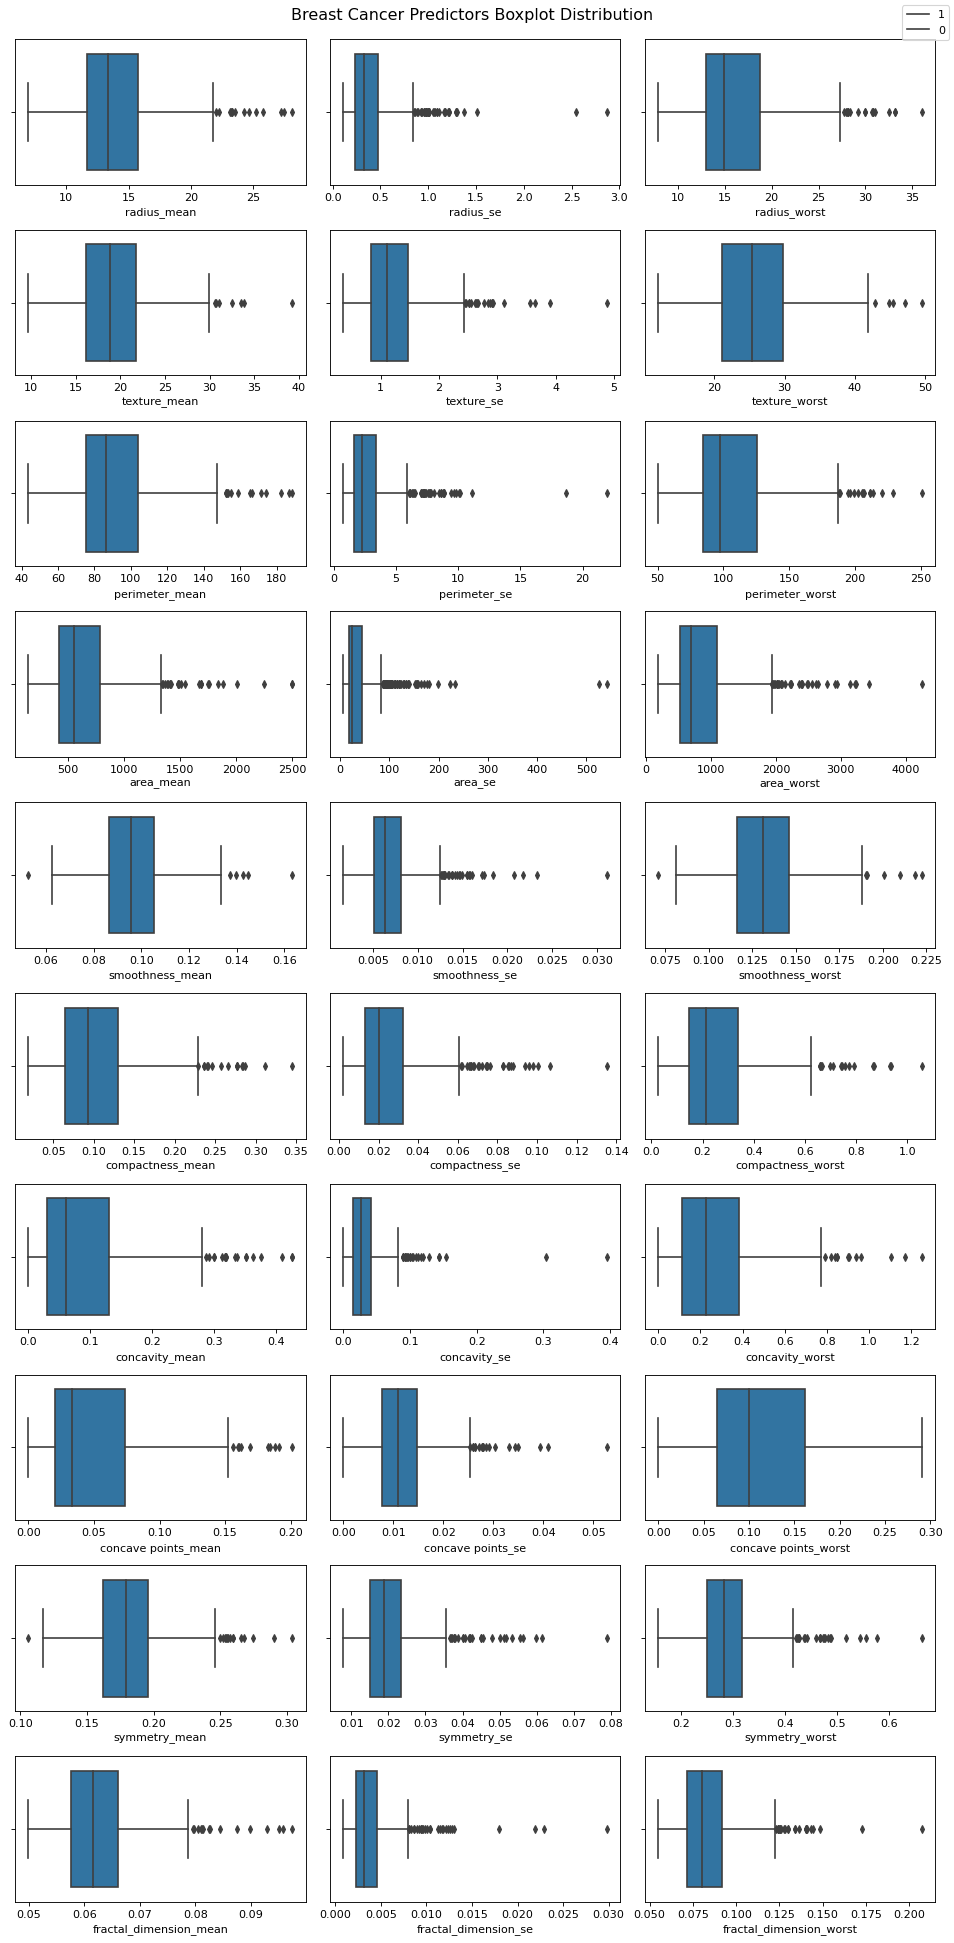

In [33]:
predictor_cols = df.columns.to_list()[1:]

_ = plot_univariate_boxplot(df=df, predictor=predictor_cols)

## Correlation Plots

Through the definitions given on the features of the dataset, we know that there are some features that are correlated to each other. For example, we can even make some hypothesis before we plot.

---

<div class="alert alert-info" role="alert">
    <b>Hypothesis:</b> Radius Mean, Area Mean and Perimeter Mean are correlated. This makes sense as if a cell nucleus is approximately circle, then the radius $r$ is related linearly with perimeter $2\pi r$ and quadratically related with area $\pi r ^2$.</b>
</div>

### Heatmap

We can plot a simple correlation heatmap to visualize the "hot spots" in which the correlation value is high.

In [34]:
def plot_heatmap(df: pd.DataFrame, predictors: List[str], cmap: str) -> pd.DataFrame:
    """This function takes in a dataframe and a list of predictors, and output the correlation matrix, as well as a plot of heatmap.

    1. Note that annot_kws attempts to make the size of the font visible and contained in the heatmap.
    2. Note that the CMAP is reversed and darker color indicates higher correlation as I find this more intuitive.

    Args:
        df (pd.DataFrame): [description]
        predictors (List[str]): [description]

    Returns:
        pd.DataFrame: [description]
    """

    corr = df[predictors].corr()
    annot_kws = {"size": 35 / np.sqrt(len(corr))}
    
    fig, _ = plt.subplots(figsize=(16, 12))
    sns.heatmap(corr, annot=True, cmap=cmap, annot_kws=annot_kws)
    return corr

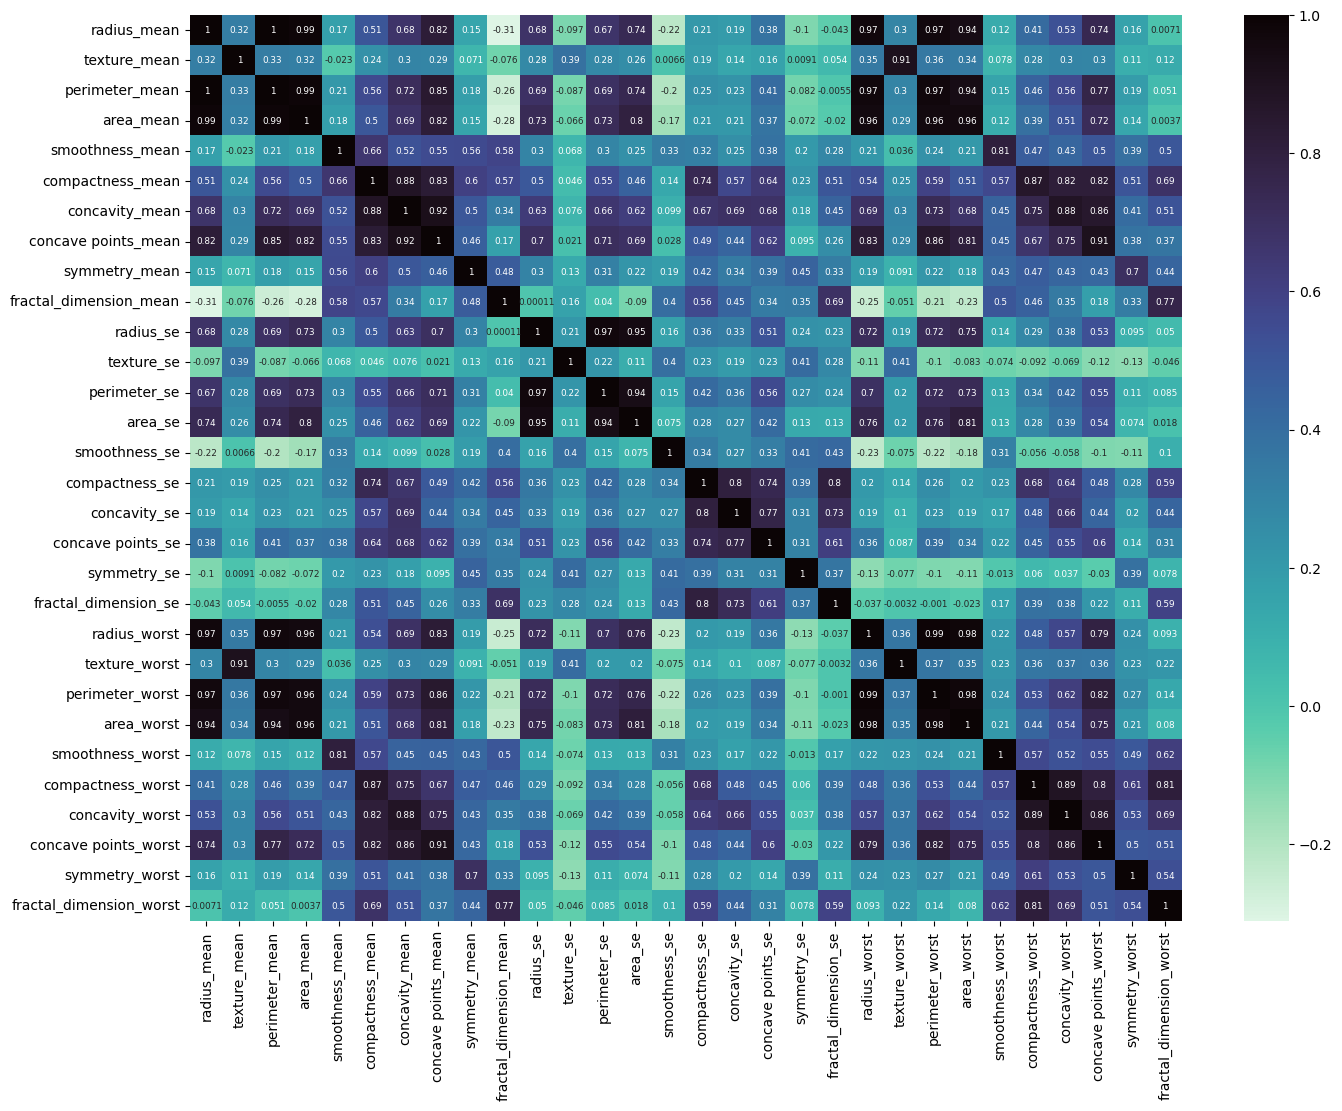

In [35]:
corr_matrix = plot_heatmap(df=df, predictors=predictor_cols, cmap=config.cmap_reversed)

From the correlation plot above, we discovered quite a lot of features being correlated, indicating multi-collinearity. We can further strengthen our stance by using a `clusterplot` to check.

### Cluster Plot

We can use a Hierarchical Clustering to visualize the correlated clusters, the Cluster Map outputs a [Dendrogram](https://www.displayr.com/what-is-dendrogram/) and in our Seaborn plot, we used [Ward's Linkage](https://www.statistics.com/glossary/wards-linkage/#:~:text=Ward%C2%B4s%20linkage%20is,clusters%20into%20a%20single%20cluster.) as our method and the distance metric is Euclidean's Distance. Hence, in the diagram below, the dendrogram implies A and B are more "correlated" than A and C.

<figure>
<img src='https://drive.google.com/uc?id=19-_nhzMW5ug2uOTTuecDjMdgCbq8WrIK' width="500" align="center"/>
<figcaption align = "center"><b>Courtesy of <a href="https://www.displayr.com/what-is-dendrogram/">What is a Dendrogram?</a></b></figcaption>
</figure>

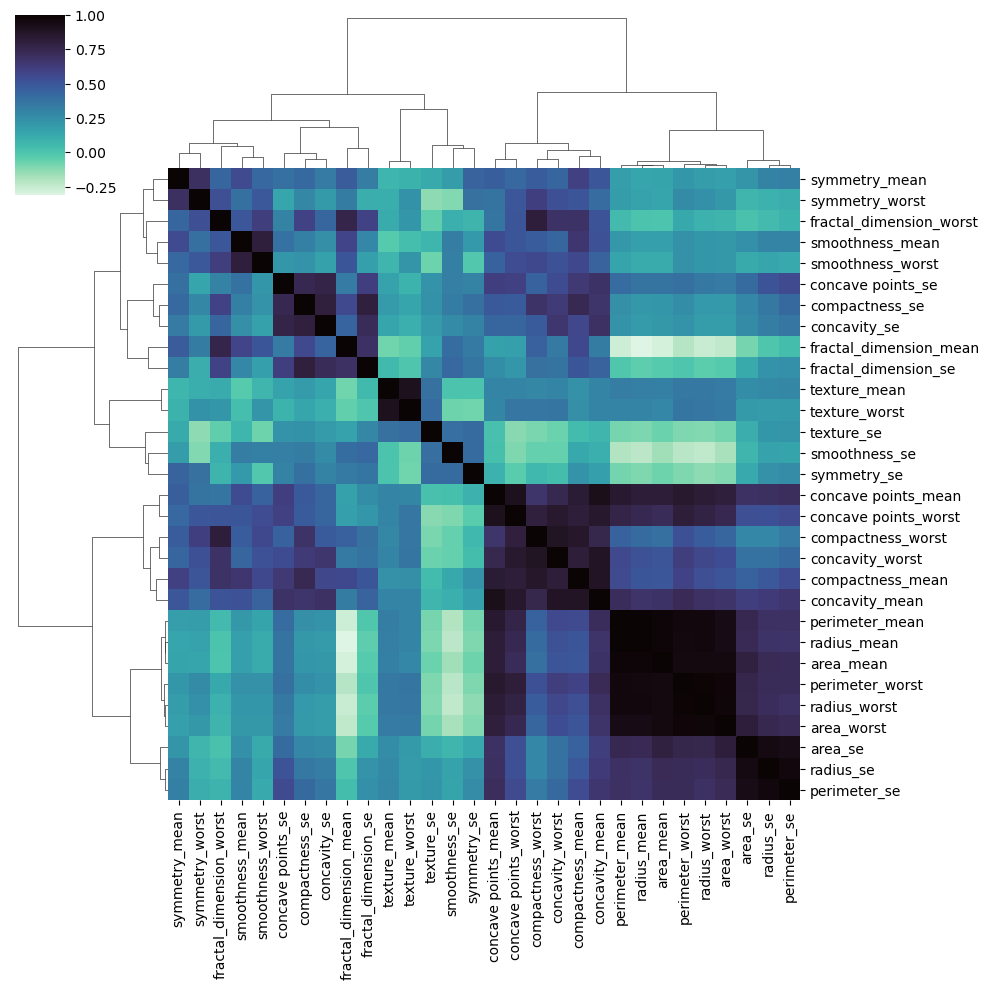

In [36]:
corr = df[predictor_cols].corr()
g = sns.clustermap(corr,method="ward",metric='euclidean', cmap=config.cmap_reversed);

## Bivariate Analysis

<div class="alert alert-block alert-warning">
<b>Clutter Alert:</b> Now we have 30 predictors, if we plot all of them in the pairplots below, we will roughly have ${30 \choose 2} = 435$ such figures, which is not really pleasing to look at. We can zoom in on a few predictors and see if we can find more insights. 
</div>

---

A good way is to be selective when you do pair plots. From the correlation plot above, we can further choose a set of correlated features and plot them. For our purpose, we will plot 10 features only, all of them are related to the mean of the features.

---

The plot will have its diagonal conveniently displaying its univariate histogram and kde distribution, while the off-diagonal will show bivariate scatter plots.

In [37]:
mean_cols = predictor_cols[:10]

In [38]:
def corrfunc(x: np.ndarray, y: np.ndarray, ax=None, **kws) -> None:
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f"{r:.1f}", xy=(0.7, 0.15), xycoords=ax.transAxes)

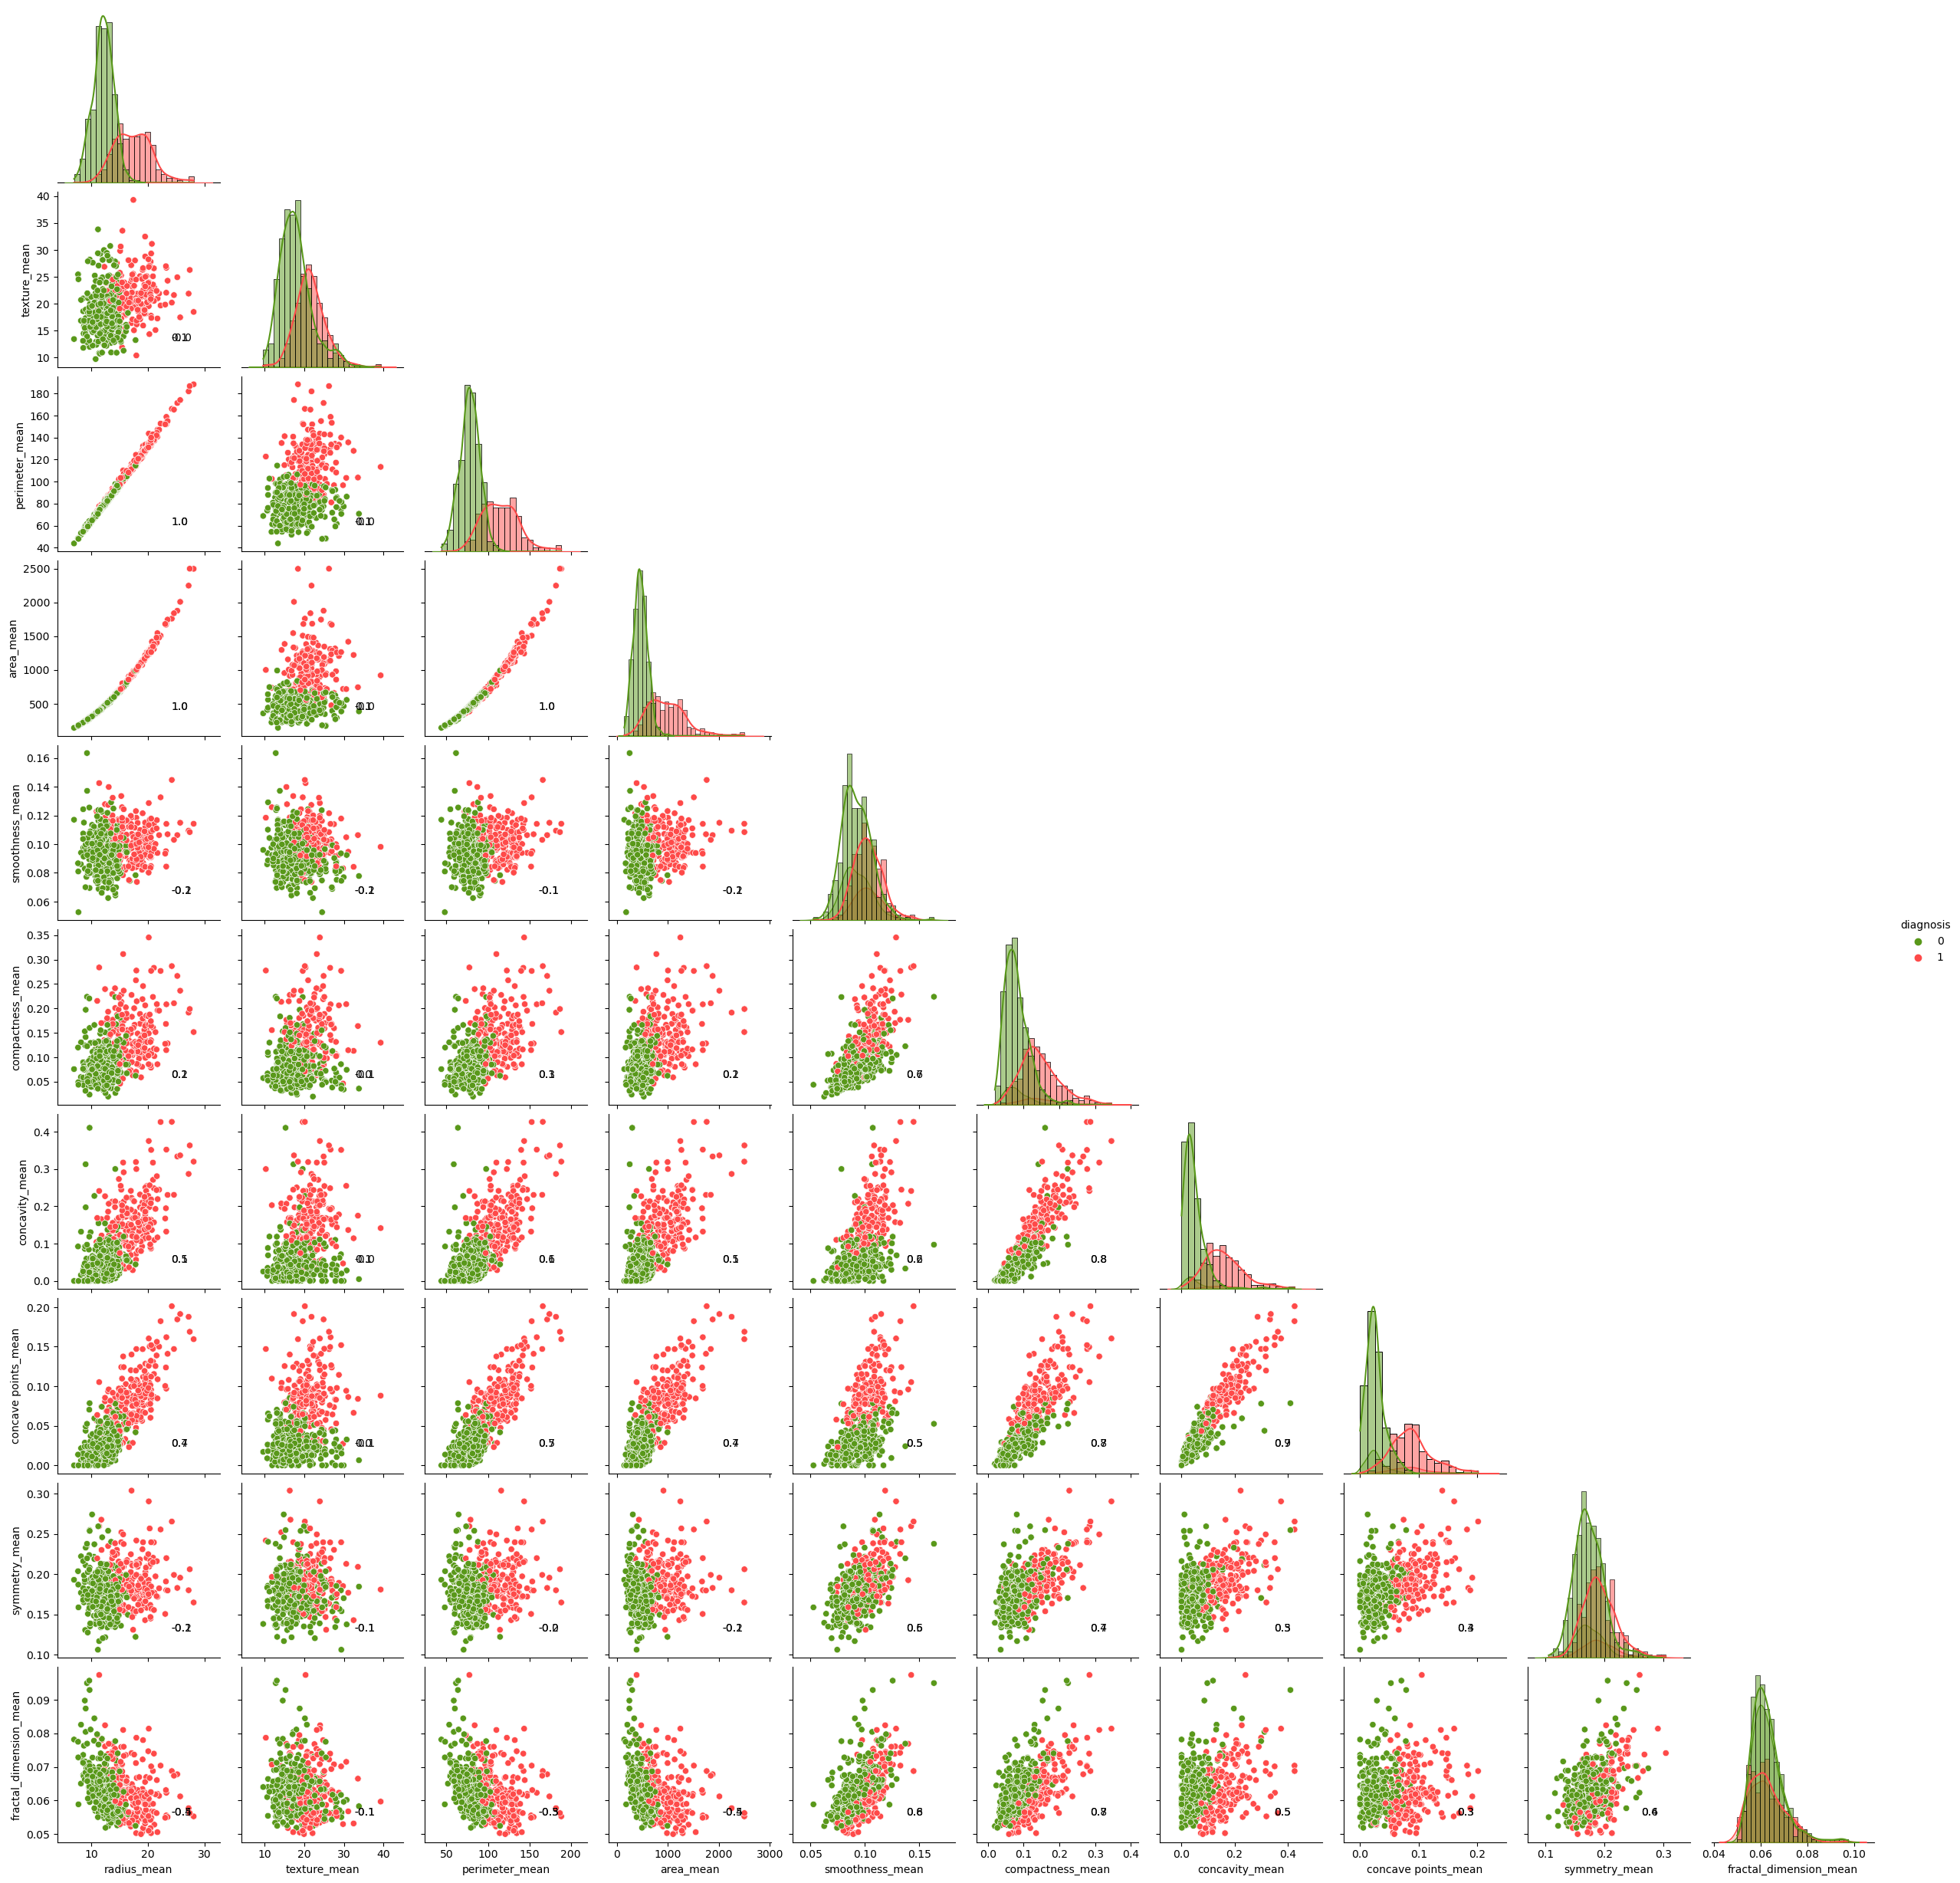

In [40]:
pp_mean = sns.pairplot(
    df,
    hue="diagnosis",
    vars=mean_cols,
    palette={1: config.colors[0], 0: config.colors[3]},
    diag_kind="auto",
    corner=True,
)

pp_mean = pp_mean.map_offdiag(sns.scatterplot)
pp_mean = pp_mean.map_diag(sns.histplot, kde=True)
pp_mean = pp_mean.map_lower(corrfunc)

From the pairplot, we notice interesting things like the three "good brothers", radius, area and perimeter, whom are highly positively correlated.

## PCA, TSNE

We can also plot PCA and TSNE to get a feel of how "separable" the data points are in 2 dimensional space.

<div class="alert alert-block alert-danger">
<b>Standardization Alert:</b> <br>
    A disclaimer/assumption here is that we are standardizing the full training set for the purpose of visualizations, and both PCA and TSNE benefit from data on the same scale. Note that preprocessing techniques such as standardization should not be applied to the test/hold-out set, as this will cause data leakage.
</div>


In [55]:
def plot_dimensional_reduction(df: pd.DataFrame, predictor_cols: List[str], colors: List[str]):
    """Plots PCA and TSNE for visualization of higher dimension to lower dimension.

    Args:
        df (pd.DataFrame): [description]
        predictor_cols (List[str]): [description]
        colors (List[str]): [description]
    """
    X_standardized = preprocessing.StandardScaler().fit_transform(df[predictor_cols])

    # Binary classification: we can set n components to 2 to better visualize all features in 2 dimensions
    pca = decomposition.PCA(n_components=2)
    pca_2d = pca.fit_transform(X_standardized)

    tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1500)
    tsne_2d = tsne.fit_transform(X_standardized)

    # Plot the TSNE and PCA visuals side-by-side
    plt.figure(figsize=(16, 11))
    plt.subplot(121)
    plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=df["diagnosis"], edgecolor="None", alpha=0.35)
    plt.colorbar()
    plt.title("PCA Scatter Plot")
    plt.subplot(122)
    plt.scatter(
        tsne_2d[:, 0],
        tsne_2d[:, 1],
        c=df["diagnosis"],
        edgecolor="None",
        alpha=0.35,
    )
    plt.colorbar()
    plt.title("TSNE Scatter Plot")
    plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.000s...
[t-SNE] Computed neighbors for 569 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 1.522404
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.643181
[t-SNE] KL divergence after 1450 iterations: 0.916428


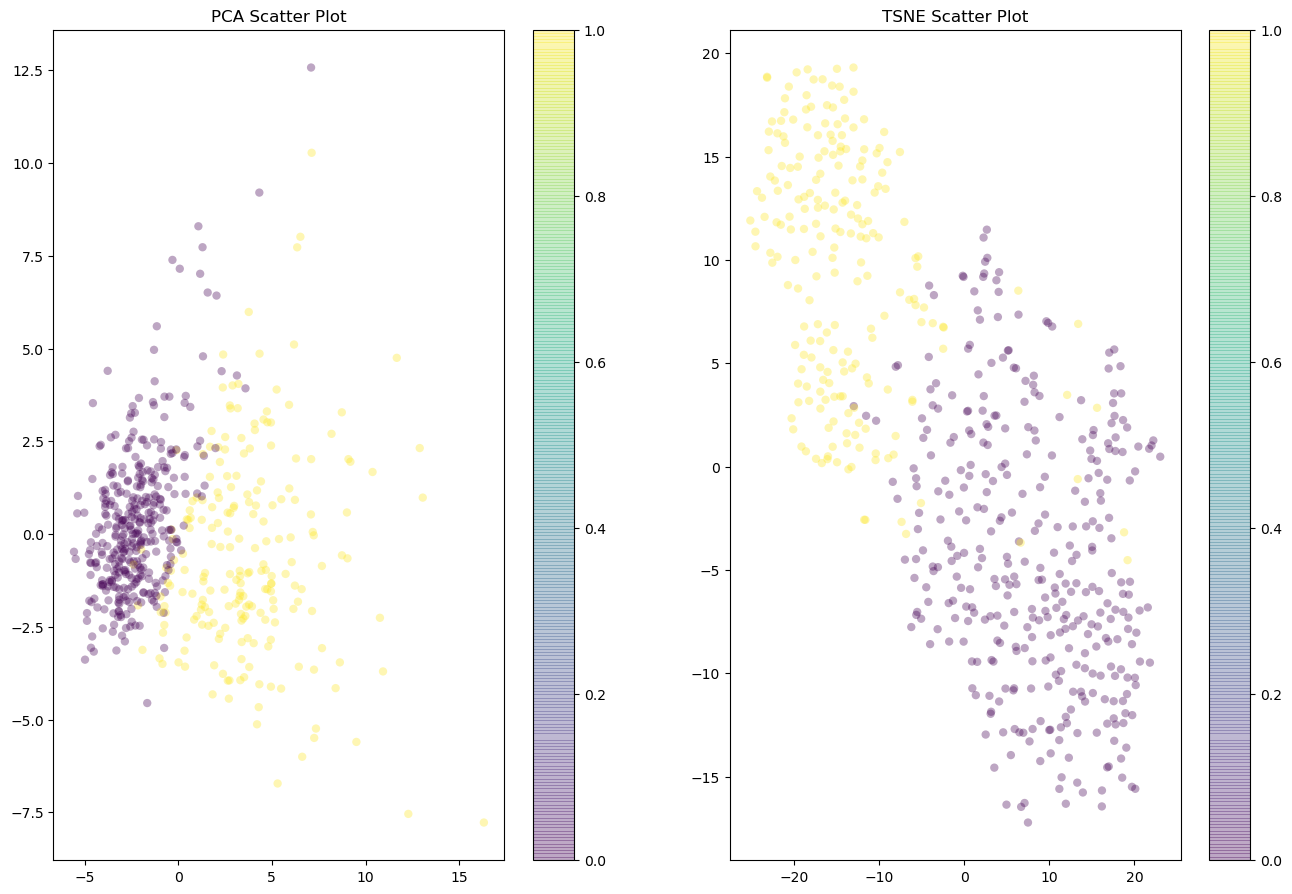

In [56]:
_ = plot_dimensional_reduction(df=df, predictor_cols=predictor_cols, colors=[config.colors[0], config.colors[1]])

Welp, the purpose of this plot is to show how well separated the data points are in 2d-space (binary classification). It does seem that TSNE can distinguish the clusters clearer than PCA. This may suggest that your data points are non-linear, which is one assumption that PCA takes. We are not restricted to only linear models, so this is fine!

## Save the Data

Although there are no changes here, we still save the data for keeping. 

In [18]:
df.to_csv(config.processed_data_stage_2, index=False)